In [25]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import pickle
import pandas as pd


import de embedding

In [26]:
embedding_matrix = np.load("../../vs_embedders/embedding_matrix.npy", allow_pickle=True)

In [27]:
with open("../../vs_embedders/ids.pkl", "rb") as file:
    ids = pickle.load(file)

In [28]:
embedding_matrix[0].shape

(128,)

Cluster con 3 nodos
Cluster con 4 nodos
Cluster con 5 nodos
Cluster con 6 nodos
Cluster con 7 nodos
Cluster con 8 nodos
Cluster con 9 nodos
Cluster con 10 nodos
Cluster con 11 nodos
Cluster con 12 nodos
Cluster con 13 nodos
Cluster con 14 nodos
Cluster con 15 nodos


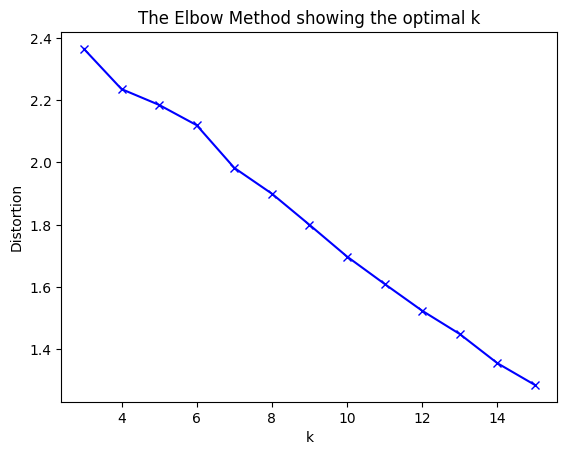

In [29]:
distortions = []
K = range(3,16)
for k in K:
    print(f"Cluster con {k} nodos")
    k_cluster = KMeans(n_clusters=k, max_iter=500, random_state=3425).fit(embedding_matrix)
    k_cluster.fit(embedding_matrix)
    distortions.append(k_cluster.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [30]:
kmeans_cluster = KMeans(n_clusters=10, init='k-means++', n_init=300, random_state=3425).fit(embedding_matrix)
kmeans_labels = kmeans_cluster.labels_

In [31]:
# run the HDBSCAN cluster
hdbs_model = hdbscan.HDBSCAN(min_cluster_size = 2)
hdbs_model.fit(embedding_matrix)
hbds_scan_labels = hdbs_model.labels_

In [32]:
# create a dataframe of the nodes with their cluster labels
nodes_labels = pd.DataFrame(zip(ids, kmeans_labels, hbds_scan_labels), columns = ['node_ids','kmeans','hdbscan'])

In [33]:
nodes_labels.hdbscan.value_counts()

hdbscan
-1    23
 1    11
 0     2
Name: count, dtype: int64

In [34]:
nodes_labels.kmeans.value_counts()

kmeans
0    7
1    5
3    4
2    4
4    3
9    3
7    3
6    3
5    2
8    2
Name: count, dtype: int64

In [35]:
import umap
embedding = umap.UMAP(n_components=2).fit(embedding_matrix)

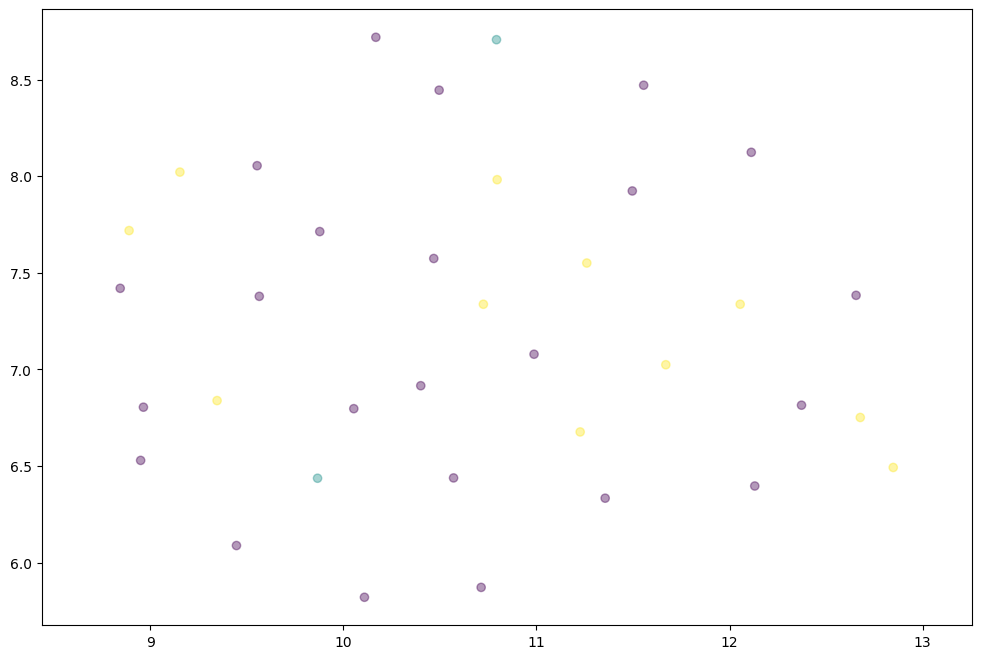

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(embedding.embedding_[:, 0], embedding.embedding_[:, 1], alpha=0.4, c=nodes_labels.hdbscan, cmap='viridis')
plt.gca().set_aspect('equal', 'datalim')
plt.show()